In [1]:
import numpy as np
import pandas as pd

import itertools
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Функции и классы

In [3]:
# разбиение на тренировочную и валидационную выборки
def train_test_split(x, y, test_size=0.3):
    indexes = range(x.shape[0])
    train_len = int(x.shape[0]*(1-test_size))

    train_indexes = np.random.choice(indexes, size=train_len, replace=False)
    test_indexes = [i for i in indexes if i not in train_indexes]

    return x[train_indexes], y[train_indexes], x[test_indexes], y[test_indexes]

In [4]:
# Класс узла дерева
class RegressionNode:
    def __init__(self, x, y, min_leaf=5, max_features=None, max_depth=None, parent=None, is_leaf=False):
        self.x = x # data
        self.y = y # target
        self.min_leaf = min_leaf # minimal objects in leaf
        self.n_features = x.shape[1]
        self.n_rows = x.shape[0]
        self.indexes = np.array(np.arange(x.shape[0]))
        self.quality = float(np.inf)
        self.feature = 0
        self.split = x[self.indexes, 0]
        self.max_features = x.shape[1] if not max_features else (max_features if max_features < x.shape[1] else x.shape[1])
        
        self.is_leaf = is_leaf
        self.parent = parent
        self.max_depth = max_depth
        self.depth = 0
        
        if not is_leaf:
            self.build()
    
    def build(self):
        features = range(self.n_features) 
        if self.n_features < self.max_features:
            features = np.random.choice(features, size=self.max_features, replace=False)
        #print("Using features: ", features)
        
        for f in features: 
            self.find_best_split(f)
            
        if self.is_leaf: 
            #print('Yes, I am leaf')
            return # this is leaf
        
        x = self.x[self.indexes, self.feature]
        lh = np.nonzero(x <= self.split)[0]
        rh = np.nonzero(x > self.split)[0]
        
        parent_node = self.parent if self.parent else self
        will_be_leaf = parent_node.depth+1 == self.max_depth if self.max_depth else False 
        if not will_be_leaf:
            parent_node.depth += 1
        
        #print(f'Making left node {lh.sum()}:{parent_node.depth} of {self.max_depth}:{will_be_leaf}')
        self.left = RegressionNode(self.x[lh], self.y[lh], min_leaf=self.min_leaf, max_features=self.max_features, max_depth=self.max_depth, parent=parent_node, is_leaf=will_be_leaf)
        #print(f'Making right node {rh.sum()}:{parent_node.depth} of {self.max_depth}:{will_be_leaf}')
        self.right = RegressionNode(self.x[rh], self.y[rh], min_leaf=self.min_leaf, max_features=self.max_features, max_depth=self.max_depth, parent=parent_node, is_leaf=will_be_leaf)
            
    def find_best_split(self, f):
        x = self.x[self.indexes, f]
        
        #print("Searching for best split, feature ",f)
        ns = np.unique(x)
        for xn in ns:
            lh = x <= xn
            rh = x > xn
            
            #print(f'{f}:{n}:{lh.sum()}:{rh.sum()}')
            
            if lh.sum() < self.min_leaf or rh.sum() < self.min_leaf:
                #print(f'Too small objects {f}:{n}')
                continue
                
            quality = self.calc_quality(lh, rh)
            
            if quality < self.quality:
                #print("Better split: ", quality)
                self.quality = quality # best quality
                self.feature = f # best feature
                self.split = xn # best split
                
            # you cannot get better quality here!
            if self.quality == np.inf:
                break
        #print("Best split found!", self.quality, self.quality == np.inf)
        self.is_leaf = self.quality == np.inf
        
    def calc_quality(self, l, r):
        y = self.y[self.indexes]
        # use mean to calc dispersion
        l_std = y[l].std() 
        r_std = y[r].std()
        
        # this is dispersion
        #return (np.sum((y[l]-l_std)**2) + np.sum((y[r]-r_std)**2)) / len(y)
        # however, this formula works better
        return l.sum() * l_std + r.sum() * r_std
    
    def predict(self, x):
        return [self.process_row(x_) for x_ in x]
    
    def process_row(self, x):
        #print('X = ', x)
        if self.is_leaf:
            #print('This is leaf')
            return self.y.mean()
        else:
            node = self.left if x[self.feature] <= self.split else self.right
            #print('Go', 'left' if x[self.feature] <= self.split else 'right', '. Used feature: ', node.feature)
            return node.process_row(x)

In [5]:
# класс Дерева
class RegressionTree:
    def fit(self, X, y, min_leaf=5, max_features=None, max_depth=None):
        self.tree = RegressionNode(X, y, min_leaf, max_features, max_depth)
        
    def predict(self, X):
        return self.tree.predict(X)

In [6]:
# класс Случайного леса
class RandomForest:
    def fit(self, X, y, k = 3, min_leafs=5, max_features=None, max_depth=None):
        self.trees = []
        for i in range(k):
            bx, by = self.get_bootstrap(X, y)
            tree = RegressionTree()
            tree.fit(bx, by, min_leafs, max_features, max_depth)
            self.trees.append(tree)
            
    def get_bootstrap(self, X, y):
        indexes = range(X.shape[0])
        r_indexes = np.random.choice(indexes, size=X.shape[0])
        
        return X[r_indexes], y[r_indexes]
    
    def predict(self, X):
        predictions = []
        
        for t in self.trees:
            predictions.append(t.predict(X))
            
        predictions = np.array(predictions)
        # print(predictions)
        result = [np.mean(predictions[:, p]) for p in range(predictions.shape[1])]
        
        return result

In [7]:
# метрика R2
def calc_r2(actual, pred):
    return 1 - (np.sum((actual - pred)**2)/np.sum((actual - actual.mean())**2))

In [8]:
# кроссвалидация
def cv(x_train, y_train, x_test, y_test, model, params, score_func):
    keys = params.keys()
    vals = params.values()
    
    perms = list(itertools.product(*vals))
    settings = [dict(zip(keys, p)) for p in perms]
    print('Total: ', len(settings))
    
    scores = []
    for s in settings:
        print('Processing: ', s)
        model.fit(x_train, y_train, **s)
        test_pred = model.predict(x_test)
        
        score = score_func(y_test, test_pred)
        print('Score: ', score)
        scores.append((s, score))
        
    print('Done')
    return max(scores, key=itemgetter(1))[0]

### Загрузка и анализ данных

In [9]:
train_df = pd.read_csv('regression_train.csv')

In [10]:
train_df.shape

(10000, 12)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [12]:
train_df.head(10)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
5,5,33.0,4.0,1650.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
6,6,53.0,1.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
7,7,60.0,3.0,1800.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
8,8,39.0,1.0,1200.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,57.0
9,9,49.0,5.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0


In [13]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


qualification          0.755963
lesson_price           0.721179
years_of_experience    0.205417
physics                0.187726
biology                0.023022
chemistry              0.017825
geography              0.014401
english                0.013174
Id                     0.004121
history               -0.000113
age                   -0.007646
Name: mean_exam_points, dtype: float64

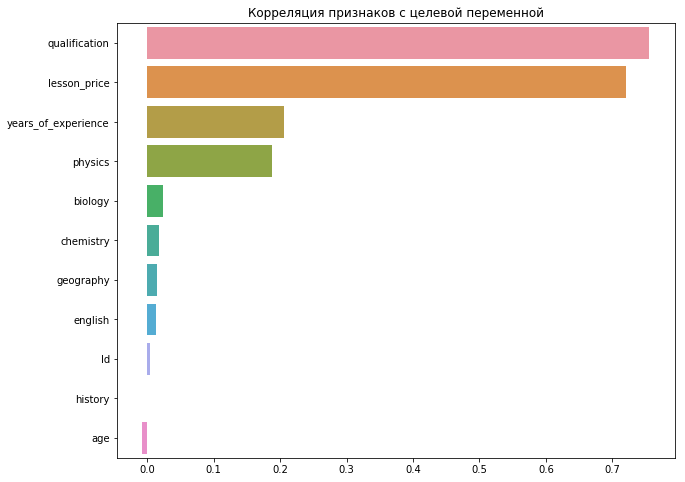

In [14]:
target_corr = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)

plt.title('Корреляция признаков с целевой переменной')
target_corr

### Подготовка данных

In [15]:
# функция выделяет дополнительные признаки из лет опыта
def split_exp(df):
    years = np.sort(df['years_of_experience'].unique().astype('int'))

    for ys in years:
        df[f'{ys}y_of_experience'] = (df['years_of_experience'] >= ys).astype('int')
    #df.drop('years_of_experience', inplace=True, axis=1)
    
    return df

In [16]:
split_exp(train_df)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,1y_of_experience,2y_of_experience,3y_of_experience,4y_of_experience,5y_of_experience,6y_of_experience,7y_of_experience,8y_of_experience,9y_of_experience,10y_of_experience
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,0,0,0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,44.0,0.0,1700.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,51.0,0.0,1700.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,34.0,1.0,1250.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
9998,9998,33.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0


9y_of_experience       0.499925
8y_of_experience       0.203889
7y_of_experience       0.102661
6y_of_experience       0.050595
years_of_experience    0.045220
5y_of_experience       0.030688
age                    0.027504
lesson_price           0.020023
4y_of_experience       0.019502
mean_exam_points       0.017479
qualification          0.016164
3y_of_experience       0.013179
physics                0.012911
2y_of_experience       0.009123
1y_of_experience       0.006213
history               -0.001407
geography             -0.001821
english               -0.002382
biology               -0.003509
chemistry             -0.003915
Id                    -0.016415
0y_of_experience            NaN
Name: 10y_of_experience, dtype: float64

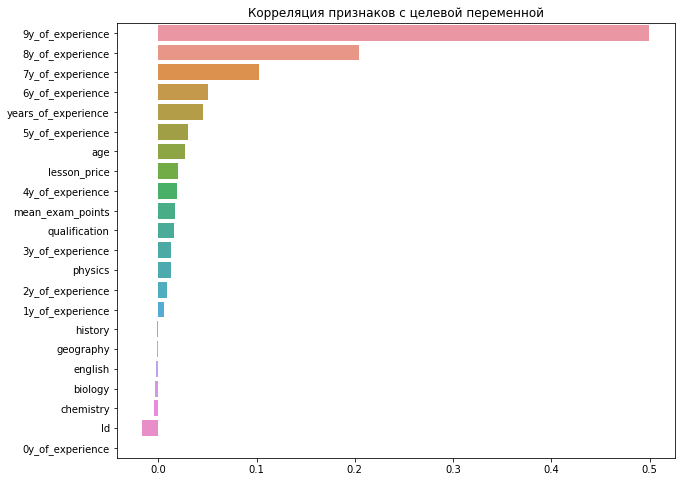

In [17]:
target_corr = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)

plt.title('Корреляция признаков с целевой переменной')
target_corr

In [18]:
train_target = train_df['mean_exam_points']
train_data = train_df.drop(['Id', 'mean_exam_points'], axis=1)

In [19]:
train_data.head(10)

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,...,1y_of_experience,2y_of_experience,3y_of_experience,4y_of_experience,5y_of_experience,6y_of_experience,7y_of_experience,8y_of_experience,9y_of_experience,10y_of_experience
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,0,0,0
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
5,33.0,4.0,1650.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,0,0,0
6,53.0,1.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
7,60.0,3.0,1800.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0
8,39.0,1.0,1200.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
9,49.0,5.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0


In [20]:
x_train, y_train, x_test, y_test = train_test_split(train_data.values, train_target.values, test_size=0.3)

### Кроссвалидация

In [21]:
p = {'min_leafs': [7,9,11,13], 'max_features': [None, 5, 7, 9, 11], 'k': [20, 30, 80, 100, 120, 180]}
#p = {'min_leafs': [5], 'max_features': [None], 'k': [1]}

In [22]:
%%time
# Закомментировал, т.к. запуск этой ячейки занимает около 4 часов
# cv(x_train, y_train, x_test, y_test, f, p, calc_r2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


### Обучаем модель на лучших настройках

In [23]:
%%time
f = RandomForest()
f.fit(x_train, y_train, k=180, max_features=5, min_leafs=13, max_depth=None)

CPU times: user 4min 14s, sys: 4.14 s, total: 4min 18s
Wall time: 4min 32s


In [24]:
train_pred = f.predict(x_train)

In [25]:
calc_r2(y_train, train_pred) 

0.8225503973238707

In [26]:
test_pred = f.predict(x_test)

In [27]:
calc_r2(y_test, test_pred) 

0.7698560040082411

### Загрузка тестовых данных и сохранение предсказаний

In [28]:
test_df = pd.read_csv('regression_test.csv')

In [29]:
test_df.shape

(10000, 11)

In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [31]:
split_exp(test_df)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,1y_of_experience,2y_of_experience,3y_of_experience,4y_of_experience,5y_of_experience,6y_of_experience,7y_of_experience,8y_of_experience,9y_of_experience,10y_of_experience
0,10000,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0
2,10002,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,10003,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,...,1,1,1,1,1,1,0,0,0,0
4,10004,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995,42.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9996,19996,51.0,2.0,2200.0,3.0,0.0,1.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
9997,19997,33.0,5.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0
9998,19998,48.0,0.0,1750.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
test_df = test_df.drop(['Id'], axis=1)

In [33]:
test_df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,...,1y_of_experience,2y_of_experience,3y_of_experience,4y_of_experience,5y_of_experience,6y_of_experience,7y_of_experience,8y_of_experience,9y_of_experience,10y_of_experience
0,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0
1,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,0,0,0,0,0,0,0
2,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,0,0,0
4,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,0,0,0


In [34]:
predictions = f.predict(test_df.values)

In [35]:
res = pd.DataFrame(data=np.array(predictions).astype('float64'), columns=['mean_exam_points'])

In [36]:
res.index += 10000

In [37]:
res.to_csv('MLevanov_regression_predictions.csv', index_label='Id')